## Explorando os Dados  
### Carregando Bibliotecas  
### Visualizando os Primeiros Dados

In [41]:
# Importando as bibliotecas que vou usar
import pandas as pd
import numpy as np

# Ferramentas de modelagem e avaliação
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Classificadores que vou testar
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier

# Lidando com dados desbalanceados
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
from imblearn.pipeline import Pipeline as ImbPipeline

# Para os gráficos e visualizações
import matplotlib.pyplot as plt
import seaborn as sns

# Tirar aqueles avisos
import warnings
warnings.filterwarnings('ignore')

# Carregando o dataset
file_path = "C:\\Users\\rithiel.amaral\\Documentos\\Python\\Teste\\format_2.csv"
data = pd.read_csv(file_path)

# Explorando os primeiros dados para entender com o que estamos lidando
print(data.head())  # Ver as primeiras linhas do dataset
print(data.info())  # Informações básicas das colunas e tipos de dados
print(data.describe())  # Estatísticas resumidas do dataset


           created_at                             publisher      event_type  \
0 2024-07-01 00:00:01  058962a3-d2f4-4647-aa7f-c8b280419dec  recurrent-ping   
1 2024-07-01 00:00:01  058962a3-d2f4-4647-aa7f-c8b280419dec  recurrent-ping   
2 2024-07-01 00:00:01  058962a3-d2f4-4647-aa7f-c8b280419dec  recurrent-ping   
3 2024-07-01 00:00:01  058962a3-d2f4-4647-aa7f-c8b280419dec  recurrent-ping   
4 2024-07-01 00:00:01  058962a3-d2f4-4647-aa7f-c8b280419dec  recurrent-ping   

                ip                               user_id  geo_lat  geo_lon  \
0    ***.***.85.21  E960737F-4E36-475A-924A-9C1069BA806A -20.2606 -40.4208   
1  ***.***.167.147  B495D9F3-9F66-4BA4-AB74-B2754283EFA6 -20.2877 -40.2852   
2  ***.***.171.123  CE7FA6E1-3801-4F6E-B40E-C24381D9DEE4 -20.3003 -40.3018   
3  ***.***.174.212  CD1C6530-C8EB-4E87-B7AD-7BD1436E17C5 -20.3003 -40.3018   
4   ***.***.68.136  00648393-1822-4468-9E28-2A712B4F023A -20.3003 -40.3018   

  geo_country geo_region   geo_city  event_type_encoded 

### Imputação de Dados Faltantes ou com Erro

In [42]:
# Primeiramente, vamos substituir os valores '(null)' e 'nil' por NaN na coluna 'user_id'.  
# Isso facilita a detecção de dados ausentes, já que o pandas trabalha bem com NaN.
data['user_id'] = data['user_id'].replace(["(null)", "nil"], pd.NA)

# Agora, criamos uma coluna auxiliar chamada 'geo_combination'.  
# Essa coluna vai combinar 'ip', 'geo_lat' e 'geo_lon' em uma única string.  
# Assim, podemos identificar combinações únicas dessas informações.
data['geo_combination'] = data['ip'].astype(str) + "_" + data['geo_lat'].astype(str) + "_" + data['geo_lon'].astype(str)

# Em seguida, criamos um dicionário que mapeia cada 'geo_combination' ao 'user_id' correspondente,  
# mas apenas para os registros que possuem 'user_id' não nulo.
geo_combination_to_user_id = data.dropna(subset=['user_id']).drop_duplicates(subset='geo_combination')[['geo_combination', 'user_id']].set_index('geo_combination')['user_id'].to_dict()

# Com esse dicionário, vamos preencher os valores faltantes em 'user_id'  
# com base nas combinações únicas das outras colunas.  
# Se não houver correspondência, o valor original é mantido.
data['user_id'] = data.apply(
    lambda row: geo_combination_to_user_id.get(row['geo_combination'], row['user_id']) if pd.isna(row['user_id']) else row['user_id'], axis=1
)

# Agora, vamos criar outro dicionário para mapear 'geo_lat' e 'geo_lon'  
# às colunas 'geo_region' e 'geo_city', para registros que não tenham dados nulos.
geo_latlon_to_region_city = data.dropna(subset=['geo_region', 'geo_city']).drop_duplicates(subset=['geo_lat', 'geo_lon'])[['geo_lat', 'geo_lon', 'geo_region', 'geo_city']].set_index(['geo_lat', 'geo_lon'])[['geo_region', 'geo_city']].to_dict(orient='index')

# Definimos uma função que vai preencher as colunas 'geo_region' e 'geo_city'  
# com base na latitude e longitude. Se os valores já estiverem preenchidos, não muda nada.
def preencher_geo(row):
    lat_lon_key = (row['geo_lat'], row['geo_lon'])
    if pd.isna(row['geo_region']) or pd.isna(row['geo_city']):
        if lat_lon_key in geo_latlon_to_region_city:
            row['geo_region'] = geo_latlon_to_region_city[lat_lon_key]['geo_region'] if pd.isna(row['geo_region']) else row['geo_region']
            row['geo_city'] = geo_latlon_to_region_city[lat_lon_key]['geo_city'] if pd.isna(row['geo_city']) else row['geo_city']
    return row

# Agora aplicamos a função em todo o DataFrame para garantir que os dados estejam completos.
data = data.apply(preencher_geo, axis=1)

# Como a coluna 'geo_combination' era só auxiliar, podemos removê-la agora.
data.drop(columns=['geo_combination'], inplace=True)

# Por fim, salvo o DataFrame atualizado na variável 'df'.
df = data


### Classificação do event_type e Preparação dos Dados

Melhores Parâmetros para Random Forest: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Melhores Parâmetros para XGBoost: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 6, 'classifier__n_estimators': 200, 'classifier__objective': 'multi:softmax'}
Resultados dos Modelos: {'Random Forest': np.float64(0.176910911972768), 'XGBoost': np.float64(0.18121383452685094)}
Relatório de Classificação:               precision    recall  f1-score   support

           2       0.18      0.17      0.17      3560
           3       0.02      0.28      0.04       411
           5       0.78      0.42      0.54     15192
           6       0.02      0.15      0.03       352

    accuracy                           0.36     19515
   macro avg       0.25      0.26      0.20     19515
weighted avg       0.64      0.36      0.46     19515



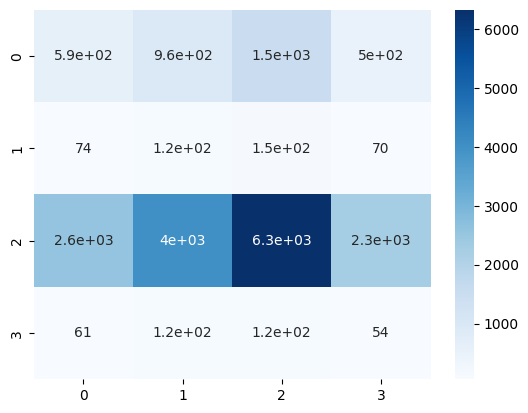

In [44]:
# Primeiro, removemos todos os valores nulos restantes para evitar problemas nos próximos passos.
df = df.dropna()

# Codificamos as variáveis categóricas.  
# A primeira é 'event_type', que será transformada em valores numéricos.
label_encoder_event = LabelEncoder()
df['event_type_encoded'] = label_encoder_event.fit_transform(df['event_type'])

# Depois, fazemos a mesma codificação para a variável 'geo_city'.
label_encoder_city = LabelEncoder()
df['geo_city_encoded'] = label_encoder_city.fit_transform(df['geo_city'])

# Agora, convertendo a coluna 'created_at' para datetime,  
# extraímos informações úteis como hora, dia, mês, e verificamos se é fim de semana.
df['created_at'] = pd.to_datetime(df['created_at'])
df['hour'] = df['created_at'].dt.hour
df['day'] = df['created_at'].dt.day
df['month'] = df['created_at'].dt.month
df['weekday'] = df['created_at'].dt.weekday
df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)

# Criamos uma nova feature chamada 'lat_lon', multiplicando latitude e longitude.
df['lat_lon'] = df['geo_lat'] * df['geo_lon']

# Aplicamos o KMeans para encontrar padrões nos dados geográficos.
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7, random_state=42)
df['geo_cluster'] = kmeans.fit_predict(df[['geo_lat', 'geo_lon']])

# Agora definimos as features (X) e o target (y).
X = df[['geo_lat', 'geo_lon', 'lat_lon', 'geo_city_encoded', 'geo_cluster']]
y = df['event_type_encoded']

# Filtramos as classes com poucas instâncias (menos de 100) para garantir uma distribuição adequada.
min_instances = 100
class_counts = y.value_counts()
classes_to_keep = class_counts[class_counts >= min_instances].index

df_filtered = df[df['event_type_encoded'].isin(classes_to_keep)].copy()

# Atualizamos X e y com os dados filtrados e reindexamos as classes.
X = df_filtered[['geo_lat', 'geo_lon', 'lat_lon', 'geo_city_encoded', 'geo_cluster']]
y = df_filtered['event_type_encoded']

label_encoder_event_filtered = LabelEncoder()
y = label_encoder_event_filtered.fit_transform(y)
class_names = [str(name) for name in label_encoder_event_filtered.classes_]

# Dividimos os dados em treino e teste (80%/20%), preservando a proporção das classes.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Escalamos as features numéricas para normalizá-las.
numeric_features = ['geo_lat', 'geo_lon', 'lat_lon']
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer([('num', numeric_transformer, numeric_features)], remainder='passthrough')

# Usamos o SMOTETomek para balancear as classes no conjunto de treino.
smt = SMOTETomek(random_state=42)
pipeline = ImbPipeline([('preprocessor', preprocessor), ('smt', smt)])
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

# Após inúmeros testes, fiz os hiperparâmetros para GridSearch em dois modelos: Random Forest e XGBoost.
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5], 'class_weight': ['balanced']}
param_grid_xgb = {'n_estimators': [100, 200], 'max_depth': [6, 10], 'learning_rate': [0.1, 0.01], 'objective': ['multi:softmax']}

rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42, eval_metric='mlogloss')

# Criamos pipelines para os modelos e realizamos GridSearch.
grid_search_rf = GridSearchCV(
    estimator=ImbPipeline([('preprocessor', preprocessor), ('smt', smt), ('classifier', rf)]),
    param_grid={'classifier__' + k: v for k, v in param_grid_rf.items()},
    scoring='f1_macro', cv=3, n_jobs=-1
)
grid_search_rf.fit(X_train, y_train)
print("Melhores Parâmetros para Random Forest:", grid_search_rf.best_params_)

grid_search_xgb = GridSearchCV(
    estimator=ImbPipeline([('preprocessor', preprocessor), ('smt', smt), ('classifier', xgb)]),
    param_grid={'classifier__' + k: v for k, v in param_grid_xgb.items()},
    scoring='f1_macro', cv=3, n_jobs=-1
)
grid_search_xgb.fit(X_train, y_train)
print("Melhores Parâmetros para XGBoost:", grid_search_xgb.best_params_)

# Avaliamos os modelos usando validação cruzada e comparamos os resultados.
models = {
    'Random Forest': grid_search_rf.best_estimator_,
    'XGBoost': grid_search_xgb.best_estimator_,
}
results = {name: cross_val_score(model, X_train, y_train, cv=3, scoring='f1_macro').mean() for name, model in models.items()}
print("Resultados dos Modelos:", results)

# Escolhemos o melhor modelo e avaliamos no conjunto de teste.
best_model = models[max(results, key=results.get)]
y_pred = best_model.predict(X_test)

print("Relatório de Classificação:", classification_report(y_test, y_pred, target_names=class_names, zero_division=0))

# Por fim, plotamos a matriz de confusão para analisar o desempenho.
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, cmap='Blues')
plt.show()


### Agregar os Dados Realizando a Contagem de Acessos por Cidade e Treinar um Modelo de Regressão

              geo_city  access_count
0         Abreu e Lima            45
1               Agudos             2
2        Agudos do Sul           100
3           Alagoinhas             1
4  Almirante Tamandare           559


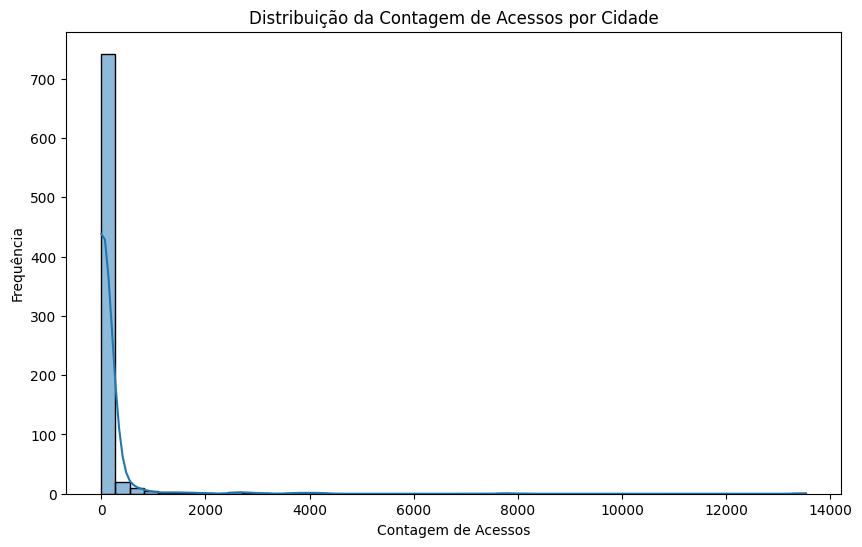

count      793.000000
mean       123.168979
std        674.607547
min          1.000000
25%          3.000000
50%          9.000000
75%         37.000000
max      13531.000000
Name: access_count, dtype: float64
Melhores hiperparâmetros:
{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
MSE: 1225180.50
MAE: 155.20
R²: 0.0188


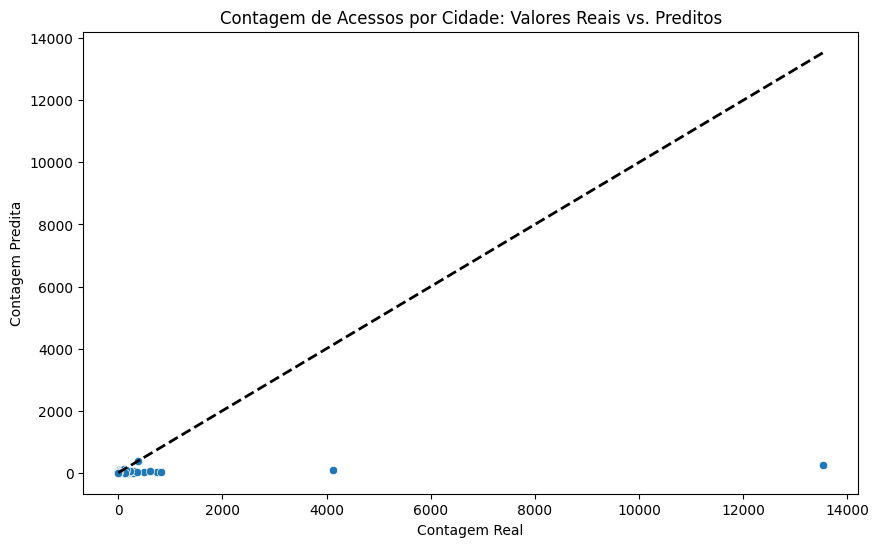

In [45]:
# Primeiro, importamos as bibliotecas que vamos utilizar.
import pandas as pd
import numpy as np

# Importamos também os modelos de regressão e ferramentas de avaliação.
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Para visualizações, usamos matplotlib e seaborn.
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Agregamos os dados para obter a contagem de acessos por cidade.
city_counts = df.groupby('geo_city').size().reset_index(name='access_count')

# Visualizamos as primeiras linhas para conferir o formato.
print(city_counts.head())

# 2. Analisamos a distribuição da contagem de acessos com um histograma.
plt.figure(figsize=(10, 6))
sns.histplot(city_counts['access_count'], bins=50, kde=True)
plt.title('Distribuição da Contagem de Acessos por Cidade')
plt.xlabel('Contagem de Acessos')
plt.ylabel('Frequência')
plt.show()

# Verificamos algumas estatísticas básicas para entender melhor a distribuição.
print(city_counts['access_count'].describe())

# Se a distribuição for muito enviesada, aplicamos uma transformação logarítmica para normalizar.
city_counts['access_count_log'] = np.log1p(city_counts['access_count'])

# 3. Agora, vamos preparar as features para o modelo.
# Calculamos as coordenadas médias (latitude e longitude) de cada cidade.
city_features = df.groupby('geo_city').agg({
    'geo_lat': 'mean',
    'geo_lon': 'mean'
}).reset_index()

# Combinamos essas coordenadas com a contagem de acessos.
city_data = pd.merge(city_counts, city_features, on='geo_city')

# Codificamos a variável categórica 'geo_city' para utilizá-la no modelo.
label_encoder_city = LabelEncoder()
city_data['geo_city_encoded'] = label_encoder_city.fit_transform(city_data['geo_city'])

# Selecionamos as features e a variável alvo.
X = city_data[['geo_city_encoded', 'geo_lat', 'geo_lon']]
y = city_data['access_count_log']  # Usamos a contagem transformada

# 4. Dividimos os dados em conjuntos de treino e teste (80%/20%).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Escalamos as features para que todas fiquem na mesma escala.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. Treinamos um modelo de regressão usando o Random Forest Regressor.
rf_regressor = RandomForestRegressor(random_state=42)

# Usamos GridSearchCV para encontrar os melhores hiperparâmetros.
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    estimator=rf_regressor,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1
)

# Ajustamos o modelo com o conjunto de treino.
grid_search.fit(X_train_scaled, y_train)
best_rf = grid_search.best_estimator_

# Exibimos os melhores hiperparâmetros encontrados.
print("Melhores hiperparâmetros:")
print(grid_search.best_params_)

# 7. Avaliamos o modelo no conjunto de teste.
y_pred = best_rf.predict(X_test_scaled)

# Como aplicamos uma transformação logarítmica, precisamos desfazê-la para avaliar corretamente.
y_test_original = np.expm1(y_test)
y_pred_original = np.expm1(y_pred)

# Calculamos as métricas de avaliação: MSE, MAE e R².
mse = mean_squared_error(y_test_original, y_pred_original)
mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)

# Exibimos as métricas.
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")

# Por fim, visualizamos os resultados em um gráfico de dispersão.
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_original, y=y_pred_original)
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'k--', lw=2)
plt.xlabel('Contagem Real')
plt.ylabel('Contagem Predita')
plt.title('Contagem de Acessos por Cidade: Valores Reais vs. Preditos')
plt.show()


Interpretação:

Número de Cidades: 793

Contagem Média de Acessos por Cidade: Aproximadamente 123

Desvio Padrão: 674,61 (muito alto)

Contagem Mínima: 1 acesso

Contagem Máxima: 13.531 acessos

Quartis: 25%: 3 acessos; 50% (Mediana): 9 acessos; 75%: 37 acessos

Observação: A distribuição da contagem de acessos é altamente assimétrica (skewed), com poucas cidades tendo contagens muito altas e a maioria das cidades tendo contagens baixas.


- Interpretação:
MSE (Erro Quadrático Médio): 1.225.180,50 (valor elevado).
MAE (Erro Absoluto Médio): 155,20.
R² (Coeficiente de Determinação): 0,0188.

- Análise:
O R² de 0,0188 indica que o modelo explica apenas 1,88% da variabilidade dos dados. Isso sugere que o modelo não está conseguindo capturar a relação entre as features e a variável alvo.
Os valores altos de MSE e MAE, em relação à média das contagens, também indicam um desempenho insatisfatório.
Possíveis Razões para o desempenho ruim.

- Features Limitadas:
As features utilizadas são geo_city_encoded, geo_lat e geo_lon.
Essas features podem não ser suficientes para prever a contagem de acessos por cidade.

### Previsão de Séries Temporais sobre a Contagem ao Longo do Tempo
Vamos agora abordar a previsão de séries temporais da contagem de acessos ao longo do tempo.

### Comparação de Estatísticas entre Cidades e Ativações
Aqui, realizamos uma análise das estatísticas descritivas por cidade e verificamos, se possível, as ativações.

Valores nulos em 'created_at': 0
          ds      y
0 2024-07-01  97673
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1 non-null      datetime64[ns]
 1   y       1 non-null      int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 148.0 bytes
None
Tamanho do conjunto de treinamento: 0
Tamanho do conjunto de teste: 1


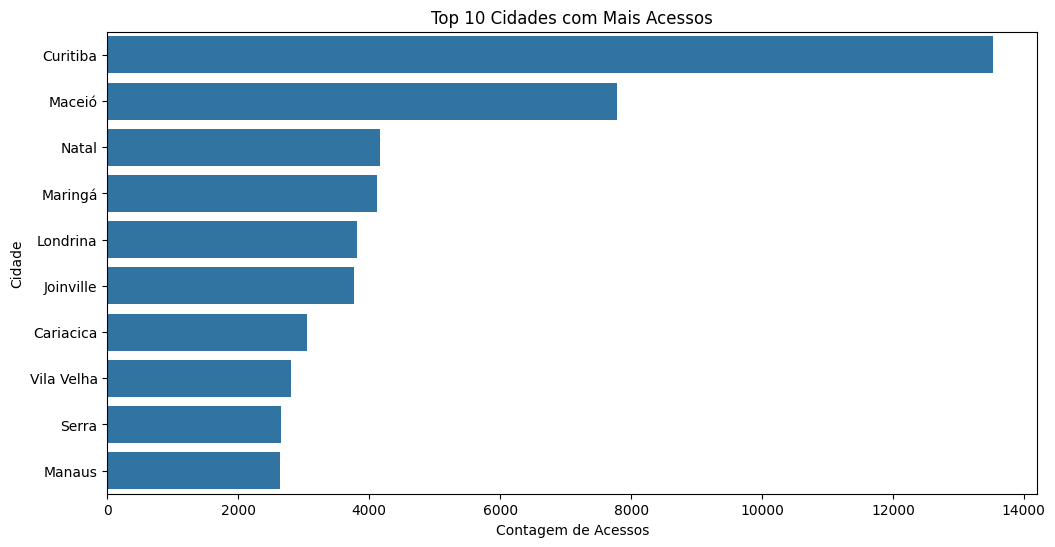

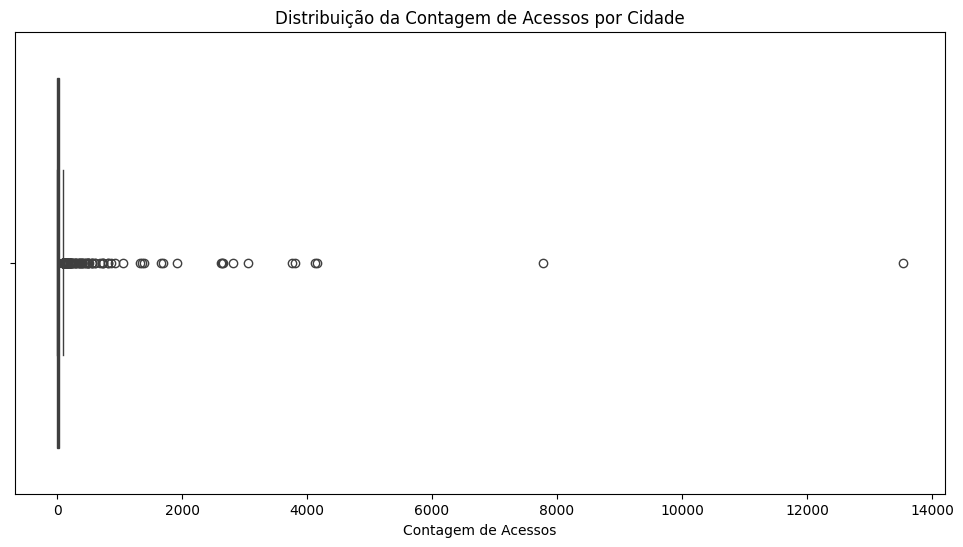

A coluna 'activation' não está presente no dataframe.


In [46]:
# Começamos convertendo a coluna 'created_at' para o tipo datetime.
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')

# Verificamos se houve algum valor nulo após a conversão para datetime.
print("Valores nulos em 'created_at':", df['created_at'].isnull().sum())

# Removemos registros que contenham datas inválidas (valores nulos).
df = df.dropna(subset=['created_at'])

# Caso as datas tenham timezones, removemos essa informação para padronizar.
df['created_at'] = df['created_at'].dt.tz_localize(None)

# Obtemos a contagem diária de acessos agrupando por data.
daily_counts = df.groupby(df['created_at'].dt.date).size().reset_index(name='y')

# Ajustamos o nome da coluna para o formato necessário na previsão ('ds' e 'y').
daily_counts.rename(columns={'created_at': 'ds'}, inplace=True)
daily_counts.rename(columns={'index': 'ds'}, inplace=True)  # Ajuste importante.

# Convertendo a coluna 'ds' para datetime para garantir consistência.
daily_counts['ds'] = pd.to_datetime(daily_counts['ds'])

# Ordenamos os dados pela data.
daily_counts = daily_counts.sort_values('ds').reset_index(drop=True)

# Visualizamos as primeiras linhas para garantir que os dados estão corretos.
print(daily_counts.head())
print(daily_counts.info())

# Dividimos os dados em treinamento (80%) e teste (20%).
train_size = int(len(daily_counts) * 0.8)
train_df = daily_counts.iloc[:train_size].copy()
test_df = daily_counts.iloc[train_size:].copy()

# Exibimos o tamanho dos conjuntos de treino e teste.
print(f"Tamanho do conjunto de treinamento: {len(train_df)}")
print(f"Tamanho do conjunto de teste: {len(test_df)}")

# Analisamos estatísticas por cidade: número de acessos e coordenadas médias.
city_stats = df.groupby('geo_city').agg({
    'event_type': 'count',
    'geo_lat': 'mean',
    'geo_lon': 'mean'
}).rename(columns={'event_type': 'access_count'}).reset_index()

# Visualizamos as 10 cidades com mais acessos.
top_cities = city_stats.sort_values(by='access_count', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='access_count', y='geo_city', data=top_cities)
plt.title('Top 10 Cidades com Mais Acessos')
plt.xlabel('Contagem de Acessos')
plt.ylabel('Cidade')
plt.show()

# Visualizamos a distribuição da contagem de acessos por cidade.
plt.figure(figsize=(12, 6))
sns.boxplot(x='access_count', data=city_stats)
plt.title('Distribuição da Contagem de Acessos por Cidade')
plt.xlabel('Contagem de Acessos')
plt.show()

# Se a coluna 'activation' estiver presente no DataFrame, faremos uma análise.
if 'activation' in df.columns:
    # Agrupamos os dados por ativação e contamos o número de acessos.
    activation_stats = df.groupby('activation').agg({
        'event_type': 'count'
    }).rename(columns={'event_type': 'access_count'}).reset_index()

    # Visualizamos a contagem de acessos por ativação.
    plt.figure(figsize=(12, 6))
    sns.barplot(x='access_count', y='activation', data=activation_stats)
    plt.title('Contagem de Acessos por Ativação')
    plt.xlabel('Contagem de Acessos')
    plt.ylabel('Ativação')
    plt.show()
else:
    print("A coluna 'activation' não está presente no dataframe.")


Não há qualquer coluna com informação de ativação, nem mesmo em 'event_type'.
Além disso a base só contém 1 dia, não permitindo uma regressão por datas, sugestão:
- Rever o processo de obtenção dos dados.
- Verificar se a coluna created_at está sendo lida corretamente a partir da fonte de dados original.
- Eu iria fazer a regressão através do Prophet, no entanto o Prophet não pode ser treinado com menos de duas observações.

### Mapa Geográfico
Agora, criamos um mapa interativo para visualizar as cidades e suas respectivas contagens de acessos.

In [40]:
import folium
from folium.plugins import MarkerCluster

# Criar um mapa centrado nas coordenadas médias
map_center = [df['geo_lat'].mean(), df['geo_lon'].mean()]
m = folium.Map(location=map_center, zoom_start=5)

# Adicionar marcadores para cada cidade
marker_cluster = MarkerCluster().add_to(m)
for idx, row in city_stats.iterrows():
    folium.Marker(
        location=[row['geo_lat'], row['geo_lon']],
        popup=f"{row['geo_city']}: {row['access_count']} acessos",
    ).add_to(marker_cluster)

# Exibir o mapa
m


### Conclusão
Modelo de Regressão: O desempenho atual é insatisfatório. Recomenda-se enriquecer os dados com novas features e possivelmente utilizar modelos mais avançados.

Previsão de Séries Temporais: Usando o Prophet, podemos modelar a contagem de acessos ao longo do tempo e identificar tendências e sazonalidades.

Comparação de Estatísticas: A análise comparativa entre cidades e ativações fornece insights valiosos que podem orientar estratégias de negócio.

Insights Possíveis:
- Identificar Cidades com Alto e Baixo Engajamento:
As cidades com maior número de acessos podem ser alvo de campanhas específicas.
- Comparar Ativações:
Se diferentes ativações estão sendo comparadas, é possível identificar quais são mais eficazes.